# Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Import required packages
from __future__ import absolute_import, division, print_function, unicode_literals
from tqdm.notebook import tqdm    # for fancy progress bar
from PIL import Image             # PILLOW for working with images
import pandas as pd               # pandas for working and manipulating data
import os                         # for performing OS realted operations
import numpy as np                # for working with numerical arrays
import matplotlib.pyplot as plt   # for matrix plots
import collections                # for working with different container datatypes
from pprint import pprint         # Pretty Printer for prinitng results differently

#Import models for NN training and loading dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, LSTM, Input, Embedding, Bidirectional, GRU, Dropout, Attention
from tensorflow.keras.optimizers import Adam



# Data Loading and Pre Processing

In [ ]:
# preprocess image data

def load_image(file):
    try:
        image = Image.open(                       # Try to open the image for the passed index from the training file
            file
        ).convert('LA').resize((64, 64))          # Resize iamges to a constant (256,256) size and convert to 8-bit greyscale image with alphas
        arr = np.array(image)                     # Create an array of image
    except:
        arr = np.zeros((64, 64, 2))               # If it throws an error,  Create an empty (zero) array of size (64,64,2)
    return arr                                    # return the array in either case.

# Create dataframe to hold train and test data
xy_train_df = pd.read_csv('/content/drive/MyDrive/cisc/A4_5/data/train_xy.csv')
x_test_df = pd.read_csv('/content/drive/MyDrive/cisc/A4_5/data/test_x.csv')

# Create a new column in dataframe to change path for loading images (since the path is different)
xy_train_df['loadpath'] = '/content/drive/MyDrive/cisc/A4_5/data/' + xy_train_df.image

# Load images from the corresponding indexes in dataframe
x_image = np.array([load_image(i) for i in tqdm(xy_train_df.loadpath)])

# Load the Summary/caption of each image from the dataframe (force convert some of the non-string cells to string)
x_text = xy_train_df.summary.astype('str')


  0%|          | 0/7627 [00:00<?, ?it/s]

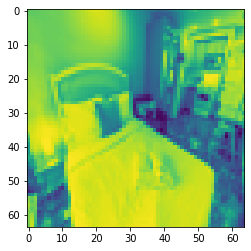

In [ ]:
# check image loading
plt.imshow(x_image[12, :, :, 0])

In [ ]:
# Create labels from trainnig dataset
y_price = xy_train_df.price
y_type = xy_train_df.type.astype('category').cat.codes    # Convert 'types' to numerical encodings

#Check for unique values and print them
len_price = len(y_price.unique())                         # Find total no. of unique values for price
len_type = len(y_type.unique())                           # Find total no. of unique values for type
print('unique values for price category', len_price, y_price.unique())
print('unique values for type category', len_type, y_type.unique())


# Create a training and validation split from the imported Training images and text
x_tr_image, x_vl_image, x_tr_text, x_vl_text, y_tr_price, y_vl_price, y_tr_type, y_vl_type = train_test_split(
    x_image,
    x_text,
    y_price,
    y_type,
    test_size=0.2)    # Use 20% of the dataset for test (validation) split

# # Print shapes of new dataset split to verify the number of images

# print(np.shape(x_tr_image))
# print(np.shape(x_vl_image))
# print(np.shape(y_tr_price))
# print(np.shape(y_vl_price))
# print(np.shape(y_tr_type))
# print(np.shape(y_vl_type))

unique values for price category 3 [1 0 2]
unique values for type category 24 [ 1 17 22 10 18 20  5  2  8  4 23 13 15 16 14 11 19  0 21  3  6 12  7  9]


In [ ]:
# Preprocess text data
vocab_size = 40000
max_len = 100

# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)             # Create a token holder object of size 40k
tokenizer.fit_on_texts(x_tr_text)                       # Create an index for vocabulary based on frequency of each word in the text


# Define a function to Preprocess and create padded text data, ensures that all the data is of same length and adds required padding
def _preprocess(list_of_text):
    return pad_sequences(                               # Return same legth padded sequences
        tokenizer.texts_to_sequences(list_of_text),     # Transform the text embeddings in the vocab into a sequence of integrers
        maxlen=max_len,                                 # Maximum legth of the text should be 100
        padding='post',                                 # Determines that padding be added at the end of strings
    )


# padding is done inside:
x_tr_text_id = _preprocess(x_tr_text)
x_vl_text_id = _preprocess(x_vl_text)

# print(x_tr_text_id.shape)
# print(x_vl_text_id.shape)

In [ ]:
pprint(tokenizer.sequences_to_texts(x_tr_text_id[:5]))

['vivre montréal sous la tente à la jonction des quartiers typiques '
 "montréalais homa village et plateau vous vous situerez à l'entrée du pont "
 "jacques cartier la terrasse bénéficie d'une intimité presque absolue "
 "imaginez vous pourriez y dormir par ces beaux soirs d'été un bbq est "
 'disponible sur la terrasse',
 'beautiful and spacious studio in nouvel hôtel spa for 4 people maximum '
 'ideally located in the heart of downtown montreal 1 kingsize bed and 1 sofa '
 'bed hair dryer oven dishwasher coffee machine oven sports room and laundry '
 'service are at your disposal sheets and towels will be provided please note '
 'that check in is between 3pm and 9pm and check out until 12pm for more '
 'information please read the detailed description below',
 'chambre dans une colocs de 3 chambres vous serez donc avec 2 autres '
 "personnes de 22 et 24 ans l'appartement se trouve dans un bloc de 5 "
 'appartements qui se partagent la terrasse ambiance très convivial pour '
 "rencon

In [ ]:
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


# Text Inputs: RNN Layers: Bi-LSTM + Bi-GRU

This block focusses on predicting prices and types using text inputs only by implementing LSTMs.

The aim is to see whether LSTMs are a good fit for given text dataset and if there is any scope of improvement.

Trials Include changed Parameters for LSTM and exploring Bi_LSTM and Comparing with Bi-GRU.



In [ ]:
# Adding LSTM Layers to the model.
in_text = Input(batch_shape=(None, max_len))                # Creating input layer
e_layer = Embedding(tokenizer.num_words, 100)(in_text)      # Creating Embeddings layer
lstm_layer = LSTM(128)(e_layer)                             # Creating LSTM Layer with space dimensions = 128

p_price = Dense(len_price, activation='softmax', name='price')(lstm_layer)

model = keras.Model(in_text,p_price, name = 'lstm_model')

model.compile(
    optimizer=Adam(),                         # Tried different optimmizers but Adam provided more reproduceable outputs
    loss='sparse_categorical_crossentropy',                    # Settings loss computation metrics for 'price'
    metrics=['SparseCategoricalAccuracy']                     # Metrics to use for evaluation during training
)

model.summary()


Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 100, 100)          4000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 price (Dense)               (None, 3)                 387       
                                                                 
Total params: 4,117,635
Trainable params: 4,117,635
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model to begin training
history = model.fit(
    x = x_tr_text_id,
    y = y_tr_price,
    epochs = 10,                                    # Training for limited no. of epoch to save time on Free Colab version and prevent Max utilization
    batch_size = 64,
    validation_data = (x_vl_text_id, y_vl_price),
    validation_split = 0.2,
    verbose = 1
)

Epoch 1/10
96/96 [==============================] - 34s 347ms/step - loss: 0.7911 - sparse_categorical_accuracy: 0.6307 - val_loss: 0.7951 - val_sparse_categorical_accuracy: 0.6501
Epoch 2/10
96/96 [==============================] - 28s 292ms/step - loss: 0.8149 - sparse_categorical_accuracy: 0.6389 - val_loss: 0.8166 - val_sparse_categorical_accuracy: 0.6311
Epoch 3/10
96/96 [==============================] - 31s 319ms/step - loss: 0.8403 - sparse_categorical_accuracy: 0.6210 - val_loss: 0.8192 - val_sparse_categorical_accuracy: 0.6298
Epoch 4/10
96/96 [==============================] - 28s 291ms/step - loss: 0.8424 - sparse_categorical_accuracy: 0.6212 - val_loss: 0.8276 - val_sparse_categorical_accuracy: 0.6298
Epoch 5/10
96/96 [==============================] - 33s 344ms/step - loss: 0.8413 - sparse_categorical_accuracy: 0.6212 - val_loss: 0.8181 - val_sparse_categorical_accuracy: 0.6298
Epoch 6/10
96/96 [==============================] - 35s 360ms/step - loss: 0.8401 - sparse_cate

**Obervation**

Results suggest further tuning could improve results.


**Next Trial: Bi-LSTM with different paramters:**

* Added Bidirectionality

* Changed Activation

* Changed Layer sizes (dimensions)

* Added Dense layers after LSTM

* Bigger Batch size, lesser epochs to save time

* MultiObjective: Predicting both **Price** and **Type**


In [ ]:
# Adding LSTM Layers to the model.
in_text = Input(batch_shape=(None, max_len))                # Creating input layer
e_layer = Embedding(tokenizer.num_words, 100)(in_text)      # Creating Embeddings layer
bi_lstm = Bidirectional(LSTM(64, activation = 'relu'))(e_layer)                  # Creating Bidirectional LSTM Layer
d_layer = Dense(32)(bi_lstm)

# Same as before
p_price = Dense(len_price, activation='softmax', name='price')(d_layer)
p_type = Dense(len_type, activation='softmax', name='type')(d_layer)

model = keras.Model(inputs = in_text, outputs = {'price':p_price, 'type':p_type}, name = 'bi-lstm_model') # Define new model for predicting both price and type

# Compile same as previous
model.compile(

    optimizer=Adam(),                                   # Using Adam as optimizer
    loss={                                              # Settings loss computation metrics for 'price' and 'text' objectives
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    loss_weights={                                      # Addditional weight coeefecients for computing weighted sum
        'price': 0.5,
        'type': 0.5,
    },
    metrics={                                           # Metrics to use for evaluation during training
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)

model.summary()

Model: "bi-lstm_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4000000     ['input_5[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          84480       ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 32)           4128        ['bidirectional[0][0]']          
                                                                                      

In [ ]:
# Fit the model to begin training -- Same as before, no Comments
history = model.fit(
    x=x_tr_text_id,
    y={'price': y_tr_price,'type': y_tr_type,},
    epochs=10,
    batch_size=128,
    validation_data=(x_vl_text_id,{'price': y_vl_price,'type': y_vl_type,}),
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5)],
    verbose=1
)

Epoch 1/10
48/48 [==============================] - 32s 671ms/step - loss: 0.5886 - price_loss: 0.5056 - type_loss: 0.6716 - price_sparse_categorical_accuracy: 0.7976 - type_sparse_categorical_accuracy: 0.8040 - val_loss: 0.8579 - val_price_loss: 0.8111 - val_type_loss: 0.9046 - val_price_sparse_categorical_accuracy: 0.6619 - val_type_sparse_categorical_accuracy: 0.7588
Epoch 2/10
48/48 [==============================] - 23s 487ms/step - loss: 0.5425 - price_loss: 0.4656 - type_loss: 0.6194 - price_sparse_categorical_accuracy: 0.8156 - type_sparse_categorical_accuracy: 0.8169 - val_loss: 0.8887 - val_price_loss: 0.8483 - val_type_loss: 0.9292 - val_price_sparse_categorical_accuracy: 0.6638 - val_type_sparse_categorical_accuracy: 0.7438
Epoch 3/10
48/48 [==============================] - 29s 596ms/step - loss: 0.4888 - price_loss: 0.4046 - type_loss: 0.5730 - price_sparse_categorical_accuracy: 0.8410 - type_sparse_categorical_accuracy: 0.8343 - val_loss: 0.9535 - val_price_loss: 0.9230 

**Trying same Model But With Bi-GRUs**

This trial compares performance of Bi-GRU with previous run of Bi-LSTM.

* Same layer size to keep it consistent.



*Code same as before, no comments.*

In [ ]:
# Adding BI-GRU.
in_text = Input(batch_shape=(None, max_len))                # Creating input layer
e_layer = Embedding(tokenizer.num_words, 100)(in_text)      # Creating Embeddings layer
bi_gru = Bidirectional(GRU(64, activation = 'relu'))(e_layer)                  # Creating Bidirectional LSTM Layer
d_layer = Dense(32)(bi_gru)

# Same as before
p_price = Dense(len_price, activation='softmax', name='price')(d_layer)
p_type = Dense(len_type, activation='softmax', name='type')(d_layer)

model = keras.Model(inputs = in_text, outputs = {'price':p_price, 'type':p_type}, name = 'bi-GRU_model') # Define new model for predicting both price and type

model.compile(

    optimizer=Adam(),                                   # Using Adam as optimizer
    loss={                                              # Settings loss computation metrics for 'price' and 'text' objectives
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    loss_weights={                                      # Addditional weight coeefecients for computing weighted sum
        'price': 0.5,
        'type': 0.5,
    },
    metrics={                                           # Metrics to use for evaluation during training
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)

model.summary()

Model: "bi-GRU_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     4000000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          63744       ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 32)           4128        ['bidirectional[0][0]']          
                                                                                       

In [ ]:
# Fit the model to begin training -- Same as before, no Comments
history = model.fit(
    x=x_tr_text_id,
    y={'price': y_tr_price,'type': y_tr_type,},
    epochs=10,
    batch_size=128,
    validation_data=(x_vl_text_id,{'price': y_vl_price,'type': y_vl_type,}),
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, restore_best_weights = 'True')],
    verbose=1
)

Epoch 1/10
48/48 [==============================] - 45s 802ms/step - loss: 1.4926 - price_loss: 0.9607 - type_loss: 2.0245 - price_sparse_categorical_accuracy: 0.5896 - type_sparse_categorical_accuracy: 0.7137 - val_loss: 0.9581 - val_price_loss: 0.8342 - val_type_loss: 1.0821 - val_price_sparse_categorical_accuracy: 0.6173 - val_type_sparse_categorical_accuracy: 0.7529
Epoch 2/10
48/48 [==============================] - 27s 564ms/step - loss: 0.8848 - price_loss: 0.7965 - type_loss: 0.9732 - price_sparse_categorical_accuracy: 0.6269 - type_sparse_categorical_accuracy: 0.7566 - val_loss: 0.9005 - val_price_loss: 0.7999 - val_type_loss: 1.0012 - val_price_sparse_categorical_accuracy: 0.6311 - val_type_sparse_categorical_accuracy: 0.7529
Epoch 3/10
48/48 [==============================] - 18s 378ms/step - loss: 0.8188 - price_loss: 0.7429 - type_loss: 0.8948 - price_sparse_categorical_accuracy: 0.6627 - type_sparse_categorical_accuracy: 0.7566 - val_loss: 0.8851 - val_price_loss: 0.7886 

In [ ]:
# Predict model and generate files for submission (Disabled to prevent unnecessary submissions.)
# y_predict = model.predict(
# x_test_summary,
# )

# price_predicted = y_predict['price']
# print(price_predicted)
# price_category_predicted = np.argmax(price_predicted, axis=1)
# print(price_category_predicted)

# pd.DataFrame({'id': x_test_df.id,'price': price_category_predicted}).to_csv('/content/drive/MyDrive/cisc/A4_5/submGRU.csv', index=False)

230/230 [==============================] - 6s 25ms/step
[[2.6408705e-01 6.3715941e-01 9.8753586e-02]
 [9.9881595e-01 1.1365864e-03 4.7415771e-05]
 [9.7829759e-01 1.8725380e-02 2.9770448e-03]
 ...
 [4.4506723e-01 4.8081037e-01 7.4122407e-02]
 [9.9997443e-01 2.4455394e-05 1.0252315e-06]
 [6.6637494e-02 8.2239866e-01 1.1096380e-01]]
[1 0 0 ... 1 0 1]


## Observation

The Bi-GRU Based model features far lesser trainable params, took roughly the same time to execute (around 20-25s at an average).

However, the Bi_GRU model performs slightly better with

**val_price_sparse_categorical_accuracy** = 63% vs 65.3%

and

**val_type_sparse_categorical_accuracy** = 72% vs 75.3%



# Text Inputs: Attention layer

This block builds on top of previous execution of Bidirectional GRU to add attention mechanism for text inputs.

Focus of prediction is limited to Price only to save time and test the performance quickly.

Disclosure: Implementation of Attention class taken from other sources. All credits to original author. I am not experienced enough to implement attention class myself :(

But the remaining implemntation is inline to other code in this assignemnt.

In [ ]:
# Implementation of Attention Class Adapted from discussion on: https://analyticsindiamag.com/a-beginners-guide-to-using-attention-layer-in-neural-networks/
# All credits to original Author for implementation
# Only used here to facilitate attention based mechanism.

from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as B
class att(Layer):

    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(att,self).__init__()

    def build(self, input_shape):

        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

        super(att,self).build(input_shape)

    def call(self, x):

        e = B.tanh(K.dot(x,self.W)+self.b)
        a = B.softmax(e, axis=1)
        output = x*a

        if self.return_sequences:
            return output

        return B.sum(output, axis=1)

In [ ]:
# Creating a sequential model to implement attention layer

m_att = Sequential([                                                 # Begin Sequential model.
Input(batch_shape=(None, max_len)),                                  # Input layer to add inputs
Embedding(tokenizer.num_words, 100),                                 # Create embeddings
Bidirectional(GRU(64, return_sequences=True)),                       # Bi-GRU Layer, similar to previous result
att(return_sequences=False),                                         # Using the Attention layer from the class
Dense(len_price, activation='softmax', name='price'),                # Final dense layer
])

m_att.summary()

m_att.compile(
    optimizer=Adam(),                         # Tried different optimmizers but Adam provided more reproduceable outputs
    loss='sparse_categorical_crossentropy',                    # Settings loss computation metrics for 'price'
    metrics=['SparseCategoricalAccuracy']                     # Metrics to use for evaluation during training
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 100, 100)          4000000   
                                                                 
 bidirectional_17 (Bidirecti  (None, 100, 128)         63744     
 onal)                                                           
                                                                 
 attention_11 (attention)    (None, 128)               228       
                                                                 
 price (Dense)               (None, 3)                 387       
                                                                 
Total params: 4,064,359
Trainable params: 4,064,359
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model to begin training
history = m_att.fit(
    x = x_tr_text_id,
    y = y_tr_price,
    epochs = 10,
    batch_size = 32,
    validation_data = (x_vl_text_id, y_vl_price),
    validation_split = 0.2,
    verbose = 1
)

Epoch 1/10
191/191 [==============================] - 45s 215ms/step - loss: 0.8053 - sparse_categorical_accuracy: 0.6379 - val_loss: 0.7443 - val_sparse_categorical_accuracy: 0.6769
Epoch 2/10
191/191 [==============================] - 47s 244ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.7208 - val_sparse_categorical_accuracy: 0.6887
Epoch 3/10
191/191 [==============================] - 42s 219ms/step - loss: 0.5206 - sparse_categorical_accuracy: 0.7800 - val_loss: 0.7736 - val_sparse_categorical_accuracy: 0.6474
Epoch 4/10
191/191 [==============================] - 40s 212ms/step - loss: 0.4028 - sparse_categorical_accuracy: 0.8376 - val_loss: 0.8763 - val_sparse_categorical_accuracy: 0.6494
Epoch 5/10
191/191 [==============================] - 37s 193ms/step - loss: 0.3072 - sparse_categorical_accuracy: 0.8830 - val_loss: 1.1324 - val_sparse_categorical_accuracy: 0.6442
Epoch 6/10
191/191 [==============================] - 46s 242ms/step - loss: 0.2387 -

# Image Inputs: CNNs with Dropout

This block explores predicting prices / type based on image inputs only using CNNs with Dropout.

In [ ]:
# Adding Conculutional Architecture for Image based prediction (Derived from Template)
in_layer = keras.Input(batch_shape=(None, 64, 64, 2))         # Input layer to take images and resize them for the batch
conv = Conv2D(32, 5, padding = 'same')(in_layer)              # Conv Layer with 32 filters and Kernel_size = (5x5)
mxpool = MaxPool2D(2)(conv)                                   # Applying MaxPooling for dimensionality reduction
dr = Dropout(0.25)(mxpool)                                            # Applying a small Dropout
flat = Flatten()(dr)                                      # Flattening the output of Conv + Dropout

# Same as before
p_price = Dense(len_price, activation='softmax', name='price')(flat)
p_type = Dense(len_type, activation='softmax', name='type')(flat)

m_cnn = keras.Model(inputs = in_layer, outputs = {'price':p_price, 'type':p_type}, name = 'CNN_Dr_Model') # Define new model for predicting both price and type

m_cnn.compile(

    optimizer=Adam(),                                   # Using Adam as optimizer
    loss={                                              # Settings loss computation metrics for 'price' and 'text' objectives
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    loss_weights={                                      # Addditional weight coeefecients for computing weighted sum
        'price': 0.5,
        'type': 0.5,
    },
    metrics={                                           # Metrics to use for evaluation during training
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)

m_cnn.summary()                                         # Displaying the summary of the compiled architecture

Model: "CNN_Dr_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 64, 64, 32)   608         ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 32, 32, 32)  0           ['conv2d_4[0][0]']               
                                                                                                  
 dropout_3 (Dropout)            (None, 32, 32, 32)   0           ['max_pooling2d_4[0][0]']        
                                                                                       

In [ ]:
# Fit the model to begin training -- Same as before, no Comments
history = m_cnn.fit(
    x=x_tr_image,
    y={'price': y_tr_price,'type': y_tr_type,},
    epochs=10,
    batch_size=128,
    validation_data=(x_vl_image,{'price': y_vl_price,'type': y_vl_type,}),
    validation_split=0.15,
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5)],  # Call back disabled to see how it performs initially for all the epochs
    verbose=1
)

Epoch 1/10
48/48 [==============================] - 21s 408ms/step - loss: 263.4845 - price_loss: 206.8071 - type_loss: 320.1617 - price_sparse_categorical_accuracy: 0.5061 - type_sparse_categorical_accuracy: 0.5661 - val_loss: 51.2093 - val_price_loss: 17.6254 - val_type_loss: 84.7932 - val_price_sparse_categorical_accuracy: 0.5609 - val_type_sparse_categorical_accuracy: 0.7084
Epoch 2/10
48/48 [==============================] - 24s 497ms/step - loss: 32.8818 - price_loss: 15.7611 - type_loss: 50.0026 - price_sparse_categorical_accuracy: 0.5366 - type_sparse_categorical_accuracy: 0.6001 - val_loss: 24.8601 - val_price_loss: 8.7166 - val_type_loss: 41.0035 - val_price_sparse_categorical_accuracy: 0.4528 - val_type_sparse_categorical_accuracy: 0.5668
Epoch 3/10
48/48 [==============================] - 21s 429ms/step - loss: 23.1391 - price_loss: 12.6633 - type_loss: 33.6149 - price_sparse_categorical_accuracy: 0.5366 - type_sparse_categorical_accuracy: 0.6207 - val_loss: 18.6762 - val_p

**Observation:**

The performance of the model is terrible. It starts off good, and while the loss si reducing, there is no conclusible result based on val_loss. Requires further tuning and modified architecture.


The next Trial makes modifications to the CNN architecture and changes following parameters:

* Changed Activation

* Increased Dropout rate

* Added more layers




In [ ]:
# Adding Deeper Conculutional Architecture for Image based prediction

in_layer = keras.Input(batch_shape=(None, 64, 64, 2))
conv1 = Conv2D(16, 3, padding = 'same', activation = 'relu')(in_layer)      # Conv1 Layer
mxpool1 = MaxPool2D(2)(conv1)
dr1 = Dropout(0.5)(mxpool1)
conv2 = Conv2D(32, 3, padding = 'same', activation = 'relu')(dr1)           # Conv 2 Layer for deeper feature learning
mxpool2 = MaxPool2D(2)(conv2)
dr2 = Dropout(0.5)(mxpool2)
conv3 = Conv2D(64, 3, padding = 'same', activation = 'relu')(dr2)           # Conv3 Layer for even more
dr3 = Dropout(0.5)(conv3)                                                   # No maxpooling for last layer
d_layer = Dense(128, activation = 'relu')(dr3)
flat = Flatten()(d_layer)

# Same as before
p_price = Dense(len_price, activation='softmax', name='price')(flat)
p_type = Dense(len_type, activation='softmax', name='type')(flat)

m_cnn2 = keras.Model(inputs = in_layer, outputs = {'price':p_price, 'type':p_type}, name = 'CNN_Model2')
m_cnn2.compile(

    optimizer=Adam(),                                   # Using Adam as optimizer
    loss={                                              # Settings loss computation metrics for 'price' and 'text' objectives
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },

    metrics={                                           # Metrics to use for evaluation during training
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)

m_cnn2.summary()                                         # Displaying the summary of the compiled architecture

Model: "CNN_Model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_35 (Conv2D)             (None, 64, 64, 16)   304         ['input_17[0][0]']               
                                                                                                  
 max_pooling2d_25 (MaxPooling2D  (None, 32, 32, 16)  0           ['conv2d_35[0][0]']              
 )                                                                                                
                                                                                                  
 dropout_34 (Dropout)           (None, 32, 32, 16)   0           ['max_pooling2d_25[0][0]

In [ ]:
# Fit the model to begin training -- Same as before, no Comments
history = m_cnn2.fit(
    x=x_tr_image,
    y={'price': y_tr_price,'type': y_tr_type,},
    epochs=20,
    batch_size=128,
    validation_data=(x_vl_image,{'price': y_vl_price,'type': y_vl_type,}),
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
48/48 [==============================] - 36s 717ms/step - loss: 44.4613 - price_loss: 27.1838 - type_loss: 17.2774 - price_sparse_categorical_accuracy: 0.5132 - type_sparse_categorical_accuracy: 0.6660 - val_loss: 4.2114 - val_price_loss: 1.0897 - val_type_loss: 3.1218 - val_price_sparse_categorical_accuracy: 0.3283 - val_type_sparse_categorical_accuracy: 0.4600
Epoch 2/20
48/48 [==============================] - 35s 730ms/step - loss: 2.0753 - price_loss: 0.8981 - type_loss: 1.1772 - price_sparse_categorical_accuracy: 0.5645 - type_sparse_categorical_accuracy: 0.7579 - val_loss: 4.1381 - val_price_loss: 1.0711 - val_type_loss: 3.0669 - val_price_sparse_categorical_accuracy: 0.6193 - val_type_sparse_categorical_accuracy: 0.1540
Epoch 3/20
48/48 [==============================] - 35s 727ms/step - loss: 2.0089 - price_loss: 0.8773 - type_loss: 1.1315 - price_sparse_categorical_accuracy: 0.5983 - type_sparse_categorical_accuracy: 0.7582 - val_loss: 4.0701 - val_price_loss: 1.06

In [ ]:
# # Predict model and generate files for submission (Disabled to prevent unnecessary submissions.)
# y_predict = m_cnn2.predict(
#      x_test_image
# )

# price_predicted = y_predict['price']
# print(price_predicted)
# price_category_predicted = np.argmax(price_predicted, axis=1)
# print(price_category_predicted)

# pd.DataFrame({'id': x_test_df.id,'price': price_category_predicted}).to_csv('/content/drive/MyDrive/cisc/A4_5/subm3.csv', index=False)

230/230 [==============================] - 14s 59ms/step
[[0.47574157 0.34245518 0.18180327]
 [0.4837552  0.34579426 0.1704504 ]
 [0.47634816 0.34624618 0.17740567]
 ...
 [0.47505724 0.3436345  0.18130836]
 [0.49075428 0.34507975 0.16416602]
 [0.47702798 0.3470523  0.17591974]]
[0 0 0 ... 0 0 0]


# Combined Model for Multi-Modal + Multi-Objective learning

This block implements a combined version of Bi-RNN + CNN based models discussed in the above sections to combine both of their funcationality to train on both images and text sequences (summaries) together and train the model to predict both the objectives: Price and Type of apartment together.

In [ ]:
# Taking text and image inputs:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# Learning from the Text based on Bi-GRU Model
e_layer = Embedding(tokenizer.num_words, 100)(in_text)                          # Creating Embeddings layer
bi_gru = Bidirectional(GRU(64, activation = 'relu'))(e_layer)                   # Creating Bidirectional LSTM Layer
d_text = Dense(32)(bi_gru)

# Learning from the Image features using CNN Network
conv1 = Conv2D(16, 3, activation = 'softmax')(in_image)
mxpool1 = MaxPool2D(2)(conv1)
d1 = Dropout(0.5)(mxpool1)
conv2 = Conv2D(32, 3, padding = 'same', activation = 'softmax')(d1)
mxpool2 = MaxPool2D(2)(conv2)
d2 = Dropout(0.5)(mxpool2)
conv3 = Conv2D(64, 3, padding = 'same', activation = 'softmax')(d2)
d3 = Dropout(0.5)(conv3)
d_img = Dense(32, activation = 'relu')(d2)
flat = Flatten()(d_img)

# Finally combine both the Bi-GRU and CNN networks
combined = tf.concat([d_text, flat], axis=-1)


# Same as before
out_price = Dense(len_price, activation='relu', name='price')(combined)
out_type = Dense(len_type, activation='relu', name='type')(combined)


m_fin = keras.Model(inputs={'text': in_text, 'img': in_image},
                    outputs={'price': out_price,'type': out_type,}, name = 'Combined_Model')

m_fin.compile(

    optimizer=Adam(),                                   # Using Adam as optimizer
    loss={                                              # Settings loss computation metrics for 'price' and 'text' objectives
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    metrics={                                           # Metrics to use for evaluation during training
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


m_fin.summary()

Model: "Combined_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 62, 62, 16)   304         ['input_9[0][0]']                
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 31, 31, 16)  0           ['conv2d_7[0][0]']               
                                                                                                  
 dropout_6 (Dropout)            (None, 31, 31, 16)   0           ['max_pooling2d_5[0][0]']        
                                                                                     

In [ ]:
# Fit the model to begin training
history = m_fin.fit(
    x={'text': x_tr_text_id,'img': x_tr_image},
    y={'price': y_tr_price,'type': y_tr_type,},
    epochs=25,                                          # No. of epochs to train for.
    batch_size=128,                                      # Size of each batch for epoch
    validation_data=(                                   # Data used for validation to evaluate the loss
        {'text': x_vl_text_id,'img': x_vl_image},
        {'price': y_vl_price,'type': y_vl_type},),
    validation_split=0.15,                              # Perform validation on 20% Split of the training data
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = 'True')],
    verbose=1
)

**Observation:**

The combined model performs only slightly better, but it features considering both modalities and predict both outputs.

Further tuning and optimization could yield better results.
